# Title TBD

## Methods & Results
- Firstly, we need to read, wrangle and clean the data to prepare for our analysis.
We filter the variables we are going to use and set the target variable as a categorical variable.
In this step, functions including "read_csv", "colnames", "select", "mutate", and "as_factor" will be used.

- After that, we need to split our data set into training set and testing set for later classification.
In addition, we need to summarize the average value of four predictors (age, physical activity, sleep duration and heart rate) in each of the 3 groups (people without sleep disorder, with insomnia, and with sleep apnea) so that it is easier for us to compare the differences.
In this step, functions including "initial_split", "group_by" and "summarize" will be used.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
set.seed(2005)

#Read in our data.
sleep_data <- read_csv("Sleep_health_and_lifestyle_dataset.csv")
colnames(sleep_data) <- c("person_ID", "gender", "age", "occupation", "sleep_duration", "sleep_quality", "physical_activity", "stress_level", "BMI", "blood_pressure", "heart_rate", "daily_steps", "sleep_disorder")
sleep_data

Rows: 374 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Gender, Occupation, BMI Category, Blood Pressure, Sleep Disorder
dbl (8): Person ID, Age, Sleep Duration, Quality of Sleep, Physical Activity...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


person_ID,gender,age,occupation,sleep_duration,sleep_quality,physical_activity,stress_level,BMI,blood_pressure,heart_rate,daily_steps,sleep_disorder
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
374,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


In [3]:
#Tidy the data.
sleep_data <- sleep_data |>
    select(age, sleep_duration, physical_activity, blood_pressure, heart_rate, sleep_disorder) |>
    mutate(sleep_disorder = as_factor(sleep_disorder)) |>
    mutate(sleep_disorder = fct_recode(sleep_disorder, "Insomnia" = "2", "Sleep Apnea" = "1", "None" = "0")) |>
    separate(col = blood_pressure,
                           into = c("systolic_bp", "diastolic_bp"),
                           sep = "/") |>
    mutate(across(systolic_bp : diastolic_bp, as.integer))
sleep_data

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `sleep_disorder = fct_recode(...)`.
Caused by warning:
! Unknown levels in `f`: 2, 1, 0”


age,sleep_duration,physical_activity,systolic_bp,diastolic_bp,heart_rate,sleep_disorder
<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<fct>
27,6.1,42,126,83,77,None
28,6.2,60,125,80,75,None
28,6.2,60,125,80,75,None
⋮,⋮,⋮,⋮,⋮,⋮,⋮
59,8.1,75,140,95,68,Sleep Apnea
59,8.1,75,140,95,68,Sleep Apnea
59,8.1,75,140,95,68,Sleep Apnea


In [4]:
#Summarize the data set.
sleep_split <- initial_split(sleep_data, prop = 0.75, strata = sleep_disorder)
sleep_train <- training(sleep_split)
sleep_test <- testing(sleep_split)

sleep_train_means <- sleep_train |>
    group_by(sleep_disorder) |>
    summarize(mean_age = mean(age, na.rm = TRUE), mean_sleep_duration = mean(sleep_duration, na.rm = TRUE), 
              mean_PA = mean(physical_activity, na.rm = TRUE), mean_HR = mean(heart_rate, na.rm = TRUE))
sleep_train_means

sleep_disorder,mean_age,mean_sleep_duration,mean_PA,mean_HR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
None,38.82317,7.329878,57.31098,68.96341
Sleep Apnea,48.98276,6.989655,73.43103,73.05172
Insomnia,44.10526,6.601754,46.49123,70.07018


## Exploratory Data Visualization

In the following study, we are trying to investigate a relationship between the presence of sleep disorders, such as insomnia and sleep apnea, and a variety of factors including age, sleep duration, occupation and amount of physical activity. The following plot demonstrates the relationship between the number of cases of insomnia and sleep apnea, and age category of the patients.

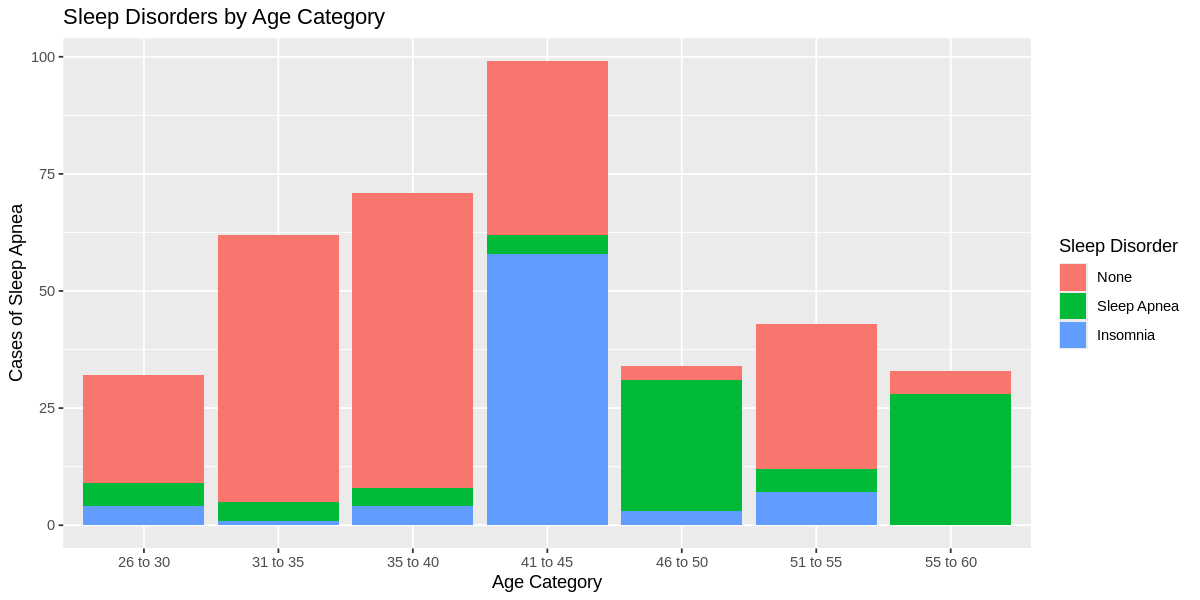

In [5]:
sleep_data_age_category <- sleep_data |>
    mutate(age_cat = case_when(age >= 20 & age <= 25 ~ "20 to 25",
                               age >= 26 & age <= 30 ~ "26 to 30",
                               age >= 31 & age <= 35 ~ "31 to 35",
                               age >= 36 & age <= 40 ~ "35 to 40",
                               age >= 41 & age <= 45 ~ "41 to 45",
                               age >= 46 & age <= 50 ~ "46 to 50",
                               age >= 51 & age <= 55 ~ "51 to 55",
                               age >= 55 & age <= 60 ~ "55 to 60"))

options(repr.plot.width = 10, repr.plot.height = 5)

sleep_plot_age <- sleep_data_age_category |>
    ggplot(aes(x=age_cat)) +
    geom_bar(aes(fill=sleep_disorder)) +
    labs(x = "Age Category", y = "Cases of Sleep Apnea", fill="Sleep Disorder") +
    ggtitle("Sleep Disorders by Age Category")

sleep_plot_age

As we can see from the following visualization, cases of insomnia peak for the people between the ages of 41 and  45, whereas sleep apnea peaks at the ages of 46 to 50 and 55 to 60. Therefore, there is a very strong correlation between the age and a particular sleep disorder.

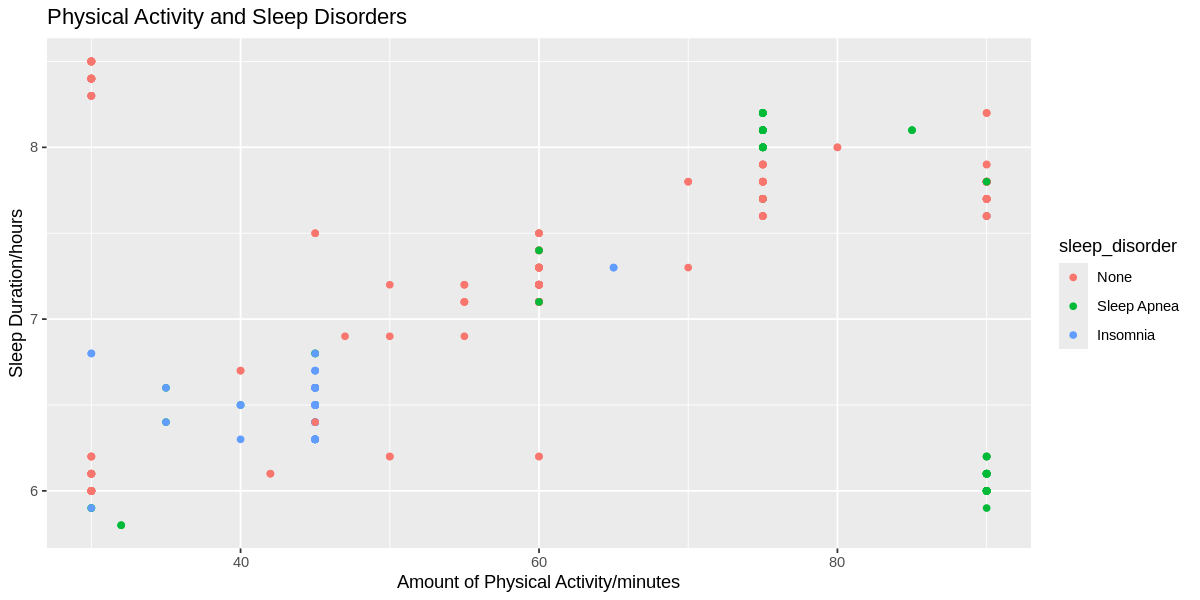

In [6]:
sleep_plot_pa <- sleep_data |>
    ggplot(aes(x=physical_activity, y=sleep_duration)) +
    geom_point(aes(color=sleep_disorder)) +
    labs(x = "Amount of Physical Activity/minutes", y = "Sleep Duration/hours") +
    ggtitle("Physical Activity and Sleep Disorders")

sleep_plot_pa

In [7]:
#sleep_plot_bmi <- sleep_data |>
#    ggplot(aes(x=BMI)) +
#    geom_bar(aes(fill=sleep_disorder)) +
#    labs(x = "BMI Category", y = "Number") +
#    ggtitle("BMI and Sleep Disorders")

#sleep_plot_bmi

## KNN Classification Analysis
To investigate our research question, k-nearest neighbour classifcation was performed using the `tidymodels` package. To find the optimal k value, we used 5-fold cross-validation on the training set.

First, we need to reprocess the data to standardize it. To do this, we used the `recipe` framework with the training data. Scaling was added with `step_scale`, and centring was added with `step_center.` 

In [8]:
# Create a recipe to standardize training data
sleep_recipe <- recipe(sleep_disorder ~., data = sleep_train) |>
                    step_center(all_predictors()) |>
                    step_scale(all_predictors())

We then created the knn model specifications by calling the `nearest_neighbor` function. To tune the model, `tune()` was used. 

In [9]:
# knn specifications with tuning
sleep_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

Next, we performed the 5-fold cross-validation on the training data using `vfold_cv` to split the data into five folds (`v`). The `strata` is set to `sleep_disorder`, our categorical label variable. We then performed the workflow analysis. The `tune_grid` function was used to help estimate the classifier accuracy for the range of k values.

In [10]:
# 5-fold cross-validation
sleep_vfold <- vfold_cv(sleep_train, v = 5, strata = sleep_disorder)

# Create a workflow with k ranging from 1 to 100
gridvals <- tibble(neighbors = seq(from = 1, to = 50))

sleep_results <- workflow() |>
                    add_recipe(sleep_recipe) |>
                    add_model(sleep_spec) |>
                    tune_grid(resamples = sleep_vfold, grid = gridvals) |>
                    collect_metrics()

accuracies <- sleep_results |>
                filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7849095,5,0.01259329,Preprocessor1_Model01
2,accuracy,multiclass,0.7919270,5,0.01146802,Preprocessor1_Model02
3,accuracy,multiclass,0.8955980,5,0.02507662,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,multiclass,0.7631470,5,0.03414219,Preprocessor1_Model48
49,accuracy,multiclass,0.7489240,5,0.02438225,Preprocessor1_Model49
50,accuracy,multiclass,0.7562548,5,0.04595285,Preprocessor1_Model50


To choose the optimal number of neighbours, we decided to plot the k versus to accuracy using`ggplot`. 

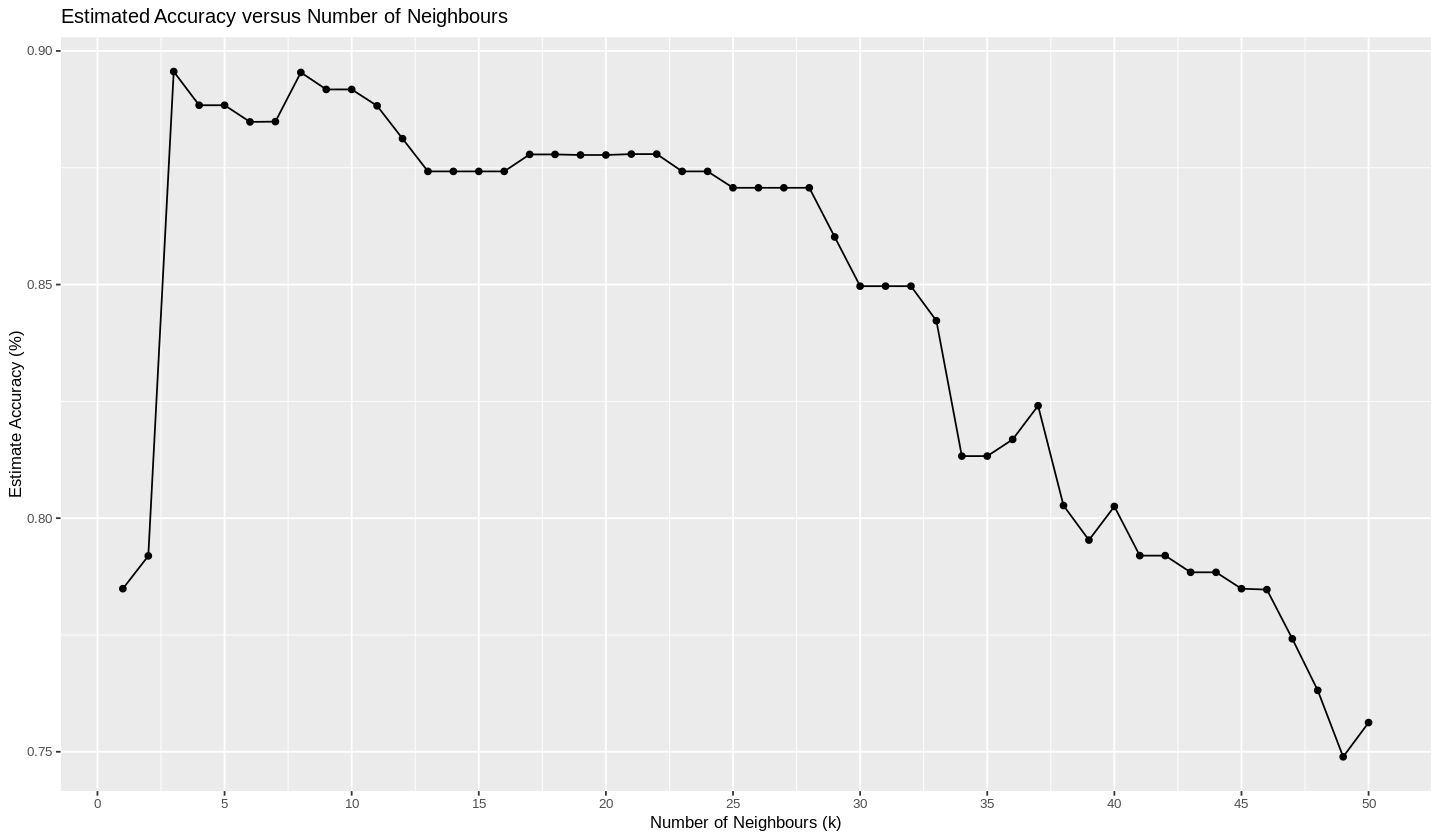

In [11]:
options(repr.plot.height = 7, repr.plot.width = 12)
k_plot <- accuracies |>
            ggplot(aes(x = neighbors, y = mean)) +
            geom_point() +
            geom_line() +
            xlab("Number of Neighbours (k)") +
            ylab("Estimate Accuracy (%)") +
            scale_x_continuous(breaks = seq(0, 50, by = 5)) +
            ggtitle("Estimated Accuracy versus Number of Neighbours") +
            theme(text = element_text(size = 10))

k_plot

Based on this visualization, the optimal k values seem to be 9, 21, or 22. Because they look so close in the visualization, we used `slice` to get a more specific read on the accuracies for comparison 

In [12]:
top_k_vals <- accuracies |>
                slice(9, 21, 22) |>
                select(neighbors, mean)
top_k_vals

neighbors,mean
<int>,<dbl>
9,0.8917667
21,0.8779265
22,0.8779265


Based on this, the optimal k value is k=9, which has the highest accuracy. This k value will be used in our final model.

To build this final model, we created a new knn model specification, now with k=9, which was determined with the cross-validation. To fit the model on the sleep data, the model specification and the data are set to the `fit` function. 

In [13]:
# Knn classification with optimal k
sleep_optimal_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
                        set_engine("kknn") |>
                        set_mode("classification")

sleep_fit <- workflow() |>
                add_recipe(sleep_recipe) |>
                add_model(sleep_optimal_spec) |>
                fit(data = sleep_train)

This final model was used to predict the test data, and the accuracy was tested by computing the metrics. To evaluate our classifcation model, we looked at the accuracy and created a confusion matrix. 

In [14]:
# Predictions on test data
sleep_predictions <- predict(sleep_fit, sleep_test) |>
                        bind_cols(sleep_test)

sleep_metrics <- sleep_predictions |>
                    metrics(truth = sleep_disorder, estimate = .pred_class) |>
                    filter(.metric == "accuracy")
sleep_metrics

sleep_confusion_matrix <- sleep_predictions |>
                            conf_mat(truth = sleep_disorder, estimate = .pred_class)
sleep_confusion_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8947368


             Truth
Prediction    None Sleep Apnea Insomnia
  None          51           0        3
  Sleep Apnea    3          20        3
  Insomnia       1           0       14

## Final Visualization ##

In [18]:
sleep_predictions

predictions_count <- sleep_predictions |>
semi_join(sleep_test) |>
group_by(sleep_disorder, .pred_class) |>
summarise(n = n())

predictions_count
      

.pred_class,age,sleep_duration,physical_activity,systolic_bp,diastolic_bp,heart_rate,sleep_disorder
<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<fct>
None,27,6.1,42,126,83,77,None
None,28,6.2,60,125,80,75,None
Sleep Apnea,29,6.3,40,140,90,82,Insomnia
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Sleep Apnea,59,8.0,75,140,95,68,Sleep Apnea
Sleep Apnea,59,8.1,75,140,95,68,Sleep Apnea
Sleep Apnea,59,8.0,75,140,95,68,Sleep Apnea


Joining with `by = join_by(age, sleep_duration, physical_activity, systolic_bp,
diastolic_bp, heart_rate, sleep_disorder)`
`summarise()` has grouped output by 'sleep_disorder'. You can override using
the `.groups` argument.


sleep_disorder,.pred_class,n
<fct>,<fct>,<int>
None,None,51
None,Sleep Apnea,3
None,Insomnia,1
⋮,⋮,⋮
Insomnia,None,3
Insomnia,Sleep Apnea,3
Insomnia,Insomnia,14


List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 13
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

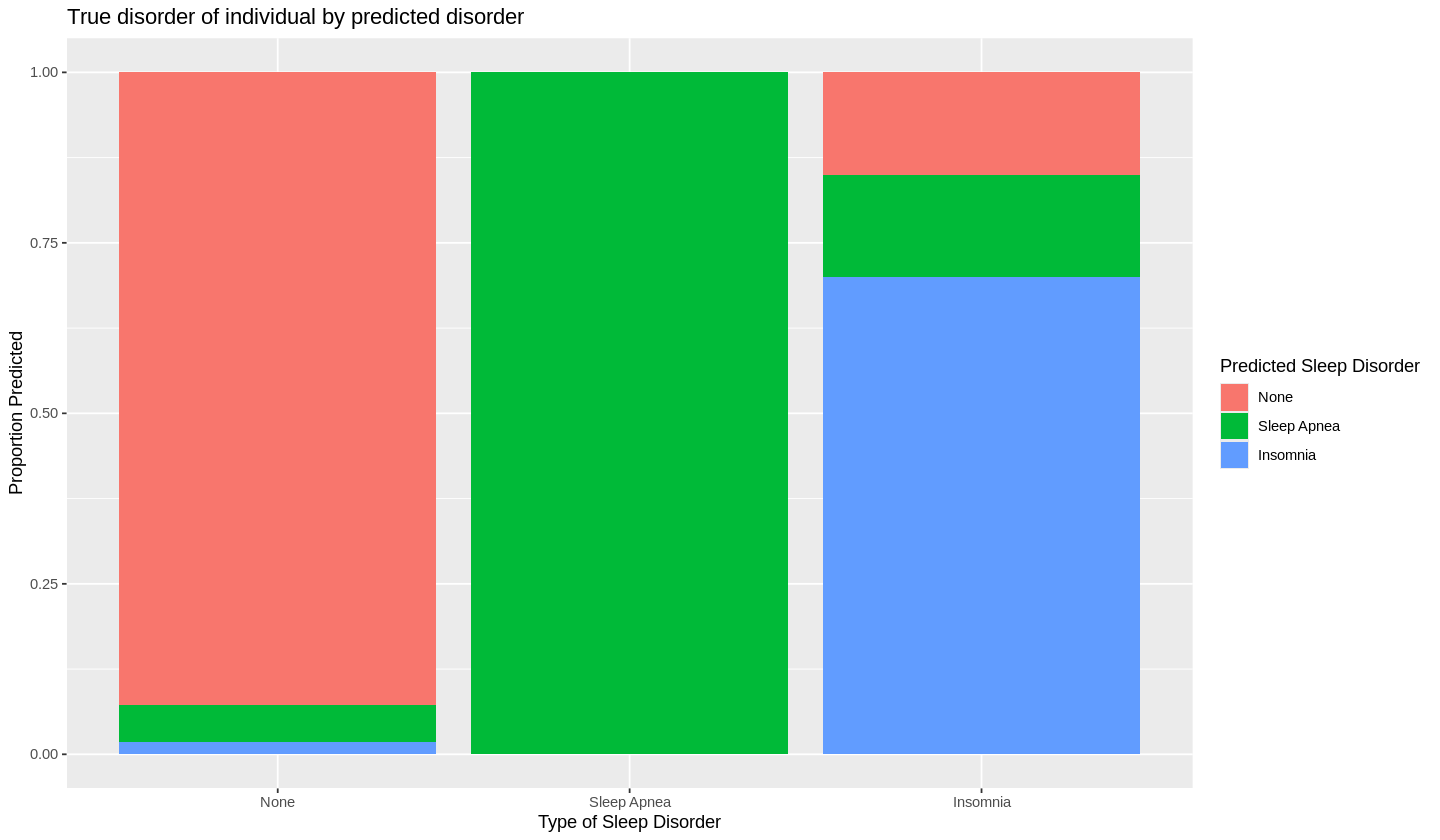

In [19]:
sleep_prediction_plot <- ggplot(predictions_count, aes( x = sleep_disorder, y = n, fill = .pred_class)) +
geom_bar(stat = "identity", position = "fill") +
labs( x = "Type of Sleep Disorder", y = "Proportion Predicted", fill = "Predicted Sleep Disorder") +
ggtitle("True disorder of individual by predicted disorder")
theme(text = element_text(size = 13)) 

sleep_prediction_plot
      